In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve
)

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [2]:
# Load + clean
df = pd.read_csv("../data/Telco-Customer-Churn.csv")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)
df = df.drop('customerID', axis=1)
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

X = df.drop('Churn', axis=1)
y = df['Churn']

cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(exclude=['object']).columns

In [3]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [4]:
log_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:,1]

print("Logistic Regression Results")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))

Logistic Regression Results
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409

ROC-AUC: 0.8421349040274871


In [5]:
rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight='balanced'
    ))
])

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

print("Random Forest Results")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))

Random Forest Results
              precision    recall  f1-score   support

           0       0.82      0.89      0.86      1035
           1       0.62      0.47      0.54       374

    accuracy                           0.78      1409
   macro avg       0.72      0.68      0.70      1409
weighted avg       0.77      0.78      0.77      1409

ROC-AUC: 0.823214239582526


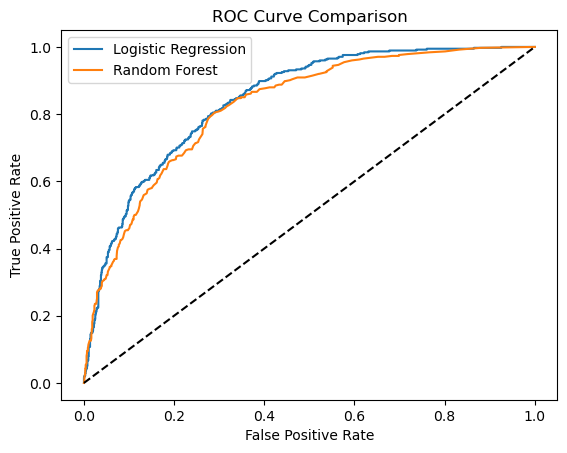

In [6]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

In [7]:
avg_revenue_per_customer = 1000  # example
predicted_churners = (y_prob_rf > 0.5).sum()
retention_success_rate = 0.3

saved_revenue = predicted_churners * avg_revenue_per_customer * retention_success_rate

print("Predicted churners:", predicted_churners)
print("Estimated monthly revenue saved: ₹", saved_revenue)

Predicted churners: 286
Estimated monthly revenue saved: ₹ 85800.0


In [8]:
final_model = log_reg

In [9]:
# Get feature names
ohe = final_model.named_steps['preprocessor'] \
                 .named_transformers_['cat'] \
                 .named_steps['onehot']

cat_feature_names = ohe.get_feature_names_out(cat_cols)
all_feature_names = np.concatenate([num_cols, cat_feature_names])

In [10]:
X_test_transformed = final_model.named_steps['preprocessor'].transform(X_test)

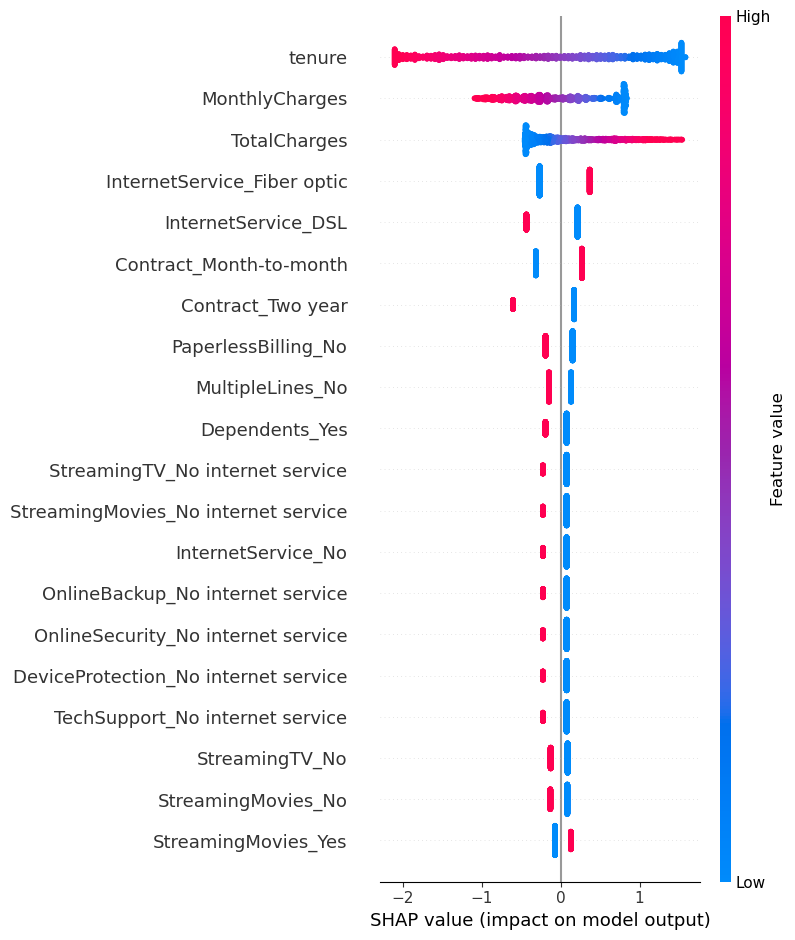

In [11]:
import shap

explainer = shap.LinearExplainer(
    final_model.named_steps['model'], 
    X_test_transformed
)

shap_values = explainer.shap_values(X_test_transformed)

shap.summary_plot(shap_values, X_test_transformed, feature_names=all_feature_names)

In [13]:
import joblib
import os

# Model folder create karein agar nahi hai toh
if not os.path.exists('../model'):
    os.makedirs('../model')

# Model save karein (notebook folder se bahar model folder mein)
joblib.dump(log_reg, '../model/churn_model.pkl')

['../model/churn_model.pkl']